In [1]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA, FactorAnalysis, SparsePCA, TruncatedSVD
except:
    !pip install matplotlib seaborn scikit-learn

try:
    import susiepca as susp
except:
    !pip install git+https://github.com/mancusolab/susiepca.git@main

In [56]:
import jax
import jax.numpy as jnp
import jax.random as jr

from sppcax.models import PFA
from sppcax import fit, transform, inverse_transform

div = sns.diverging_palette(250, 10, as_cmap=True)

jax.config.update("jax_enable_x64", True)

In [3]:
z_dim = 4
p_dim = 200
Z, W, X = susp.sim.generate_sim(seed = 0, l_dim = 40, n_dim = 150, p_dim = p_dim, z_dim = z_dim, effect_size = 1)

In [4]:
results0 = susp.infer.susie_pca(X, z_dim =z_dim, l_dim = 40, tau=10, tol=1e-3, max_iter=500)

Iter [1] | ELBO = -23834.815 | E[logl] = -18568.640 | -KL[Z] = -3189.682 | -KL[W] = -1731.723 | -KL[G] = -344.770
Iter [2] | ELBO = -20297.576 | E[logl] = -18119.903 | -KL[Z] = -1278.638 | -KL[W] = -411.050 | -KL[G] = -487.985
Iter [3] | ELBO = -19112.137 | E[logl] = -16941.932 | -KL[Z] = -1306.236 | -KL[W] = -353.360 | -KL[G] = -510.609
Iter [4] | ELBO = -18282.965 | E[logl] = -16105.860 | -KL[Z] = -1324.289 | -KL[W] = -296.900 | -KL[G] = -555.916
Iter [5] | ELBO = -17730.238 | E[logl] = -15547.584 | -KL[Z] = -1324.394 | -KL[W] = -287.318 | -KL[G] = -570.942
Iter [6] | ELBO = -17464.810 | E[logl] = -15298.487 | -KL[Z] = -1304.351 | -KL[W] = -286.089 | -KL[G] = -575.883
Iter [7] | ELBO = -17315.036 | E[logl] = -15177.131 | -KL[Z] = -1281.732 | -KL[W] = -286.282 | -KL[G] = -569.891
Iter [8] | ELBO = -17211.138 | E[logl] = -15097.136 | -KL[Z] = -1261.677 | -KL[W] = -284.728 | -KL[G] = -567.597
Iter [9] | ELBO = -17148.179 | E[logl] = -15041.886 | -KL[Z] = -1244.033 | -KL[W] = -285.522 | 

In [5]:
results1 = susp.infer.susie_pca(X, z_dim =2 * z_dim, l_dim = 80, tau=10, tol=1e-3, max_iter=500)

Iter [1] | ELBO = -26322.142 | E[logl] = -17300.111 | -KL[Z] = -5324.113 | -KL[W] = -3178.021 | -KL[G] = -519.898
Iter [2] | ELBO = -19875.022 | E[logl] = -16935.430 | -KL[Z] = -1660.873 | -KL[W] = -617.074 | -KL[G] = -661.645
Iter [3] | ELBO = -18592.272 | E[logl] = -15983.201 | -KL[Z] = -1529.369 | -KL[W] = -484.285 | -KL[G] = -595.417
Iter [4] | ELBO = -18007.136 | E[logl] = -15532.086 | -KL[Z] = -1479.955 | -KL[W] = -393.761 | -KL[G] = -601.334
Iter [5] | ELBO = -17746.703 | E[logl] = -15313.141 | -KL[Z] = -1448.925 | -KL[W] = -379.189 | -KL[G] = -605.448
Iter [6] | ELBO = -17581.038 | E[logl] = -15183.452 | -KL[Z] = -1424.587 | -KL[W] = -372.436 | -KL[G] = -600.562
Iter [7] | ELBO = -17471.771 | E[logl] = -15104.133 | -KL[Z] = -1401.262 | -KL[W] = -366.583 | -KL[G] = -599.794
Iter [8] | ELBO = -17401.775 | E[logl] = -15063.642 | -KL[Z] = -1377.860 | -KL[W] = -361.429 | -KL[G] = -598.843
Iter [9] | ELBO = -17351.271 | E[logl] = -15039.033 | -KL[Z] = -1354.313 | -KL[W] = -358.337 | 

In [6]:
results2 = susp.infer.susie_pca(X, z_dim =2 * z_dim, l_dim = 20, tau=10, tol=1e-3, max_iter=500)

Iter [1] | ELBO = -25600.127 | E[logl] = -17954.393 | -KL[Z] = -5624.649 | -KL[W] = -1706.683 | -KL[G] = -314.401
Iter [2] | ELBO = -19732.121 | E[logl] = -17345.373 | -KL[Z] = -1603.936 | -KL[W] = -331.372 | -KL[G] = -451.440
Iter [3] | ELBO = -18343.697 | E[logl] = -16134.022 | -KL[Z] = -1473.811 | -KL[W] = -284.198 | -KL[G] = -451.666
Iter [4] | ELBO = -17937.542 | E[logl] = -15819.651 | -KL[Z] = -1409.584 | -KL[W] = -233.188 | -KL[G] = -475.120
Iter [5] | ELBO = -17778.511 | E[logl] = -15706.807 | -KL[Z] = -1362.707 | -KL[W] = -228.606 | -KL[G] = -480.392
Iter [6] | ELBO = -17680.828 | E[logl] = -15639.586 | -KL[Z] = -1329.747 | -KL[W] = -228.657 | -KL[G] = -482.837
Iter [7] | ELBO = -17620.754 | E[logl] = -15607.042 | -KL[Z] = -1302.169 | -KL[W] = -228.290 | -KL[G] = -483.253
Iter [8] | ELBO = -17568.854 | E[logl] = -15575.488 | -KL[Z] = -1281.339 | -KL[W] = -228.368 | -KL[G] = -483.659
Iter [9] | ELBO = -17537.704 | E[logl] = -15558.574 | -KL[Z] = -1266.421 | -KL[W] = -228.024 | 

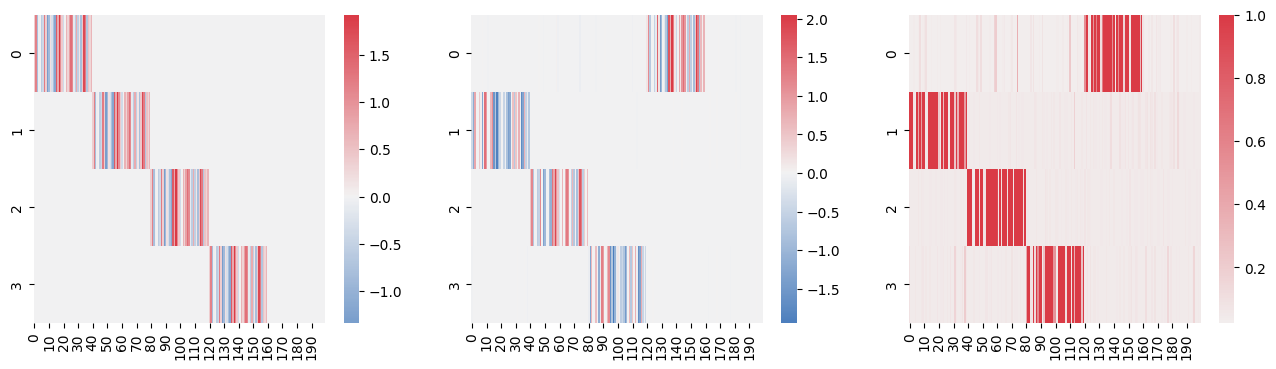

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results0.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results0.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);

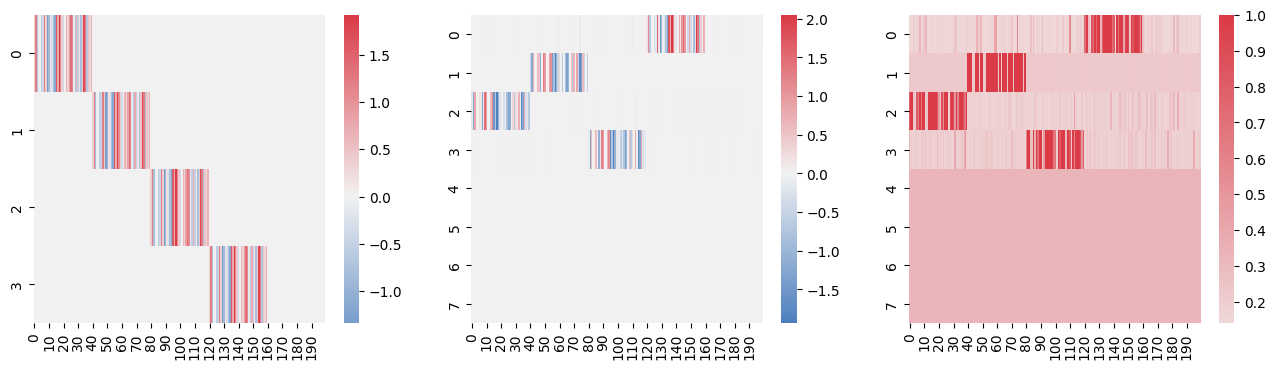

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results1.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results1.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);

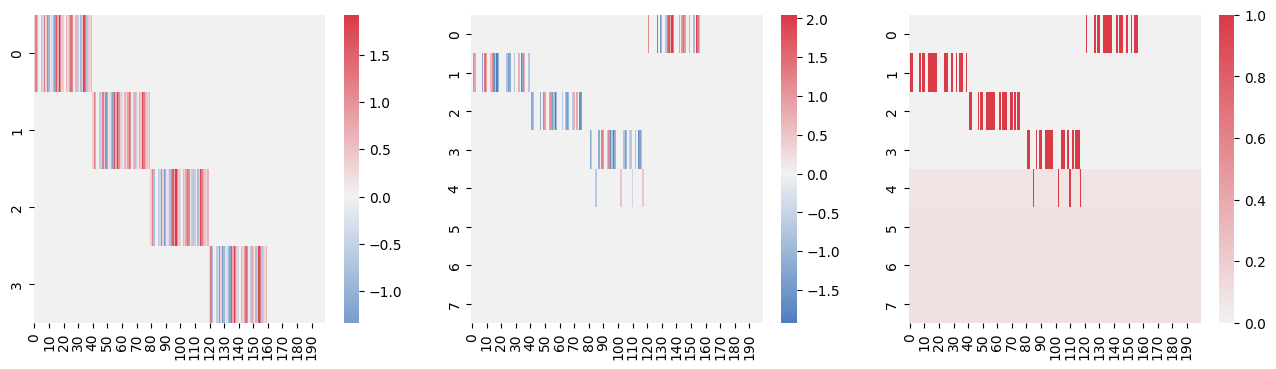

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results2.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results2.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);

Text(0.5, 1.0, 'Sparse PCA')

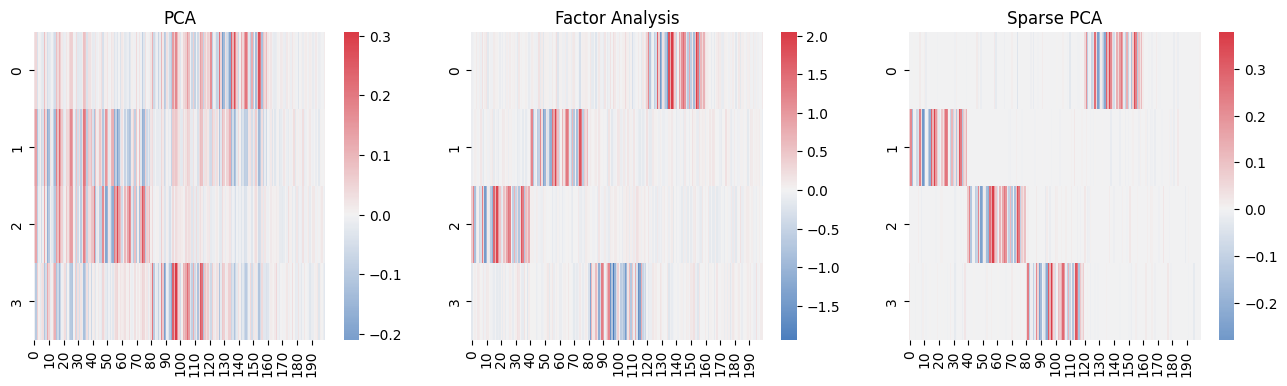

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
u, s, v = jnp.linalg.svd(X, full_matrices=False)
z_dim = 4

pca_z= (u * s[None])[..., :z_dim]

pca_w = v[:z_dim]

pca = TruncatedSVD(n_components=z_dim)
res = pca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[0])
axes[0].set_title('PCA')

fa = FactorAnalysis(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[1])
axes[1].set_title('Factor Analysis')

spca = SparsePCA(n_components=z_dim)
res = spca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[2])
axes[2].set_title('Sparse PCA')

In [11]:
n_components = 8
n_features = p_dim
key = jr.PRNGKey(1987)
fit_models = []
elbos = []
labels = []
for bmr_e_step in [False, True]:
    for bmr_m_step in [False, True]:
        for optimize_with_bmr in [False, True]:
            model = PFA(
                n_components=n_components,
                n_features=n_features,
                optimize_with_bmr=optimize_with_bmr,
                bmr_m_step=bmr_m_step,
                bmr_e_step=bmr_e_step,
                bmr_e_step_opts=('max_iter', 2, 'pi', 0.2)
            )
            
            key, _key = jr.split(key)
            fm, elbs = fit(model, X, tol=1e-3, n_iter=256, bmr_frequency=32, key=_key)
            fit_models.append(fm)
            elbos.append(elbs)
            print([bmr_e_step, bmr_m_step, optimize_with_bmr], elbos[-1][-1], len(elbos[-1]))
            labels.append('PFA')
            if optimize_with_bmr:
                labels[-1] += '+BMRO'
            if bmr_m_step:
                labels[-1] += '+BMRM'
            if bmr_e_step:
                labels[-1] += '+BMRE'

[False, False, False] -45376.77578514941 256
[False, False, True] -45087.93559713193 256
[False, True, False] -44138.296166858796 167
[False, True, True] -44051.65032333661 165
[True, False, False] -44561.50323781294 256
[True, False, True] -44471.59965308752 256
[True, True, False] -43661.6466994148 256
[True, True, True] -43622.22641749533 256


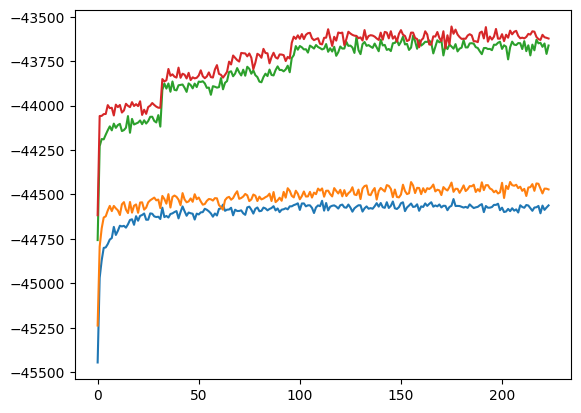

In [12]:
for elbo in elbos[4:]:
    plt.plot(elbo[-256 + 32:])

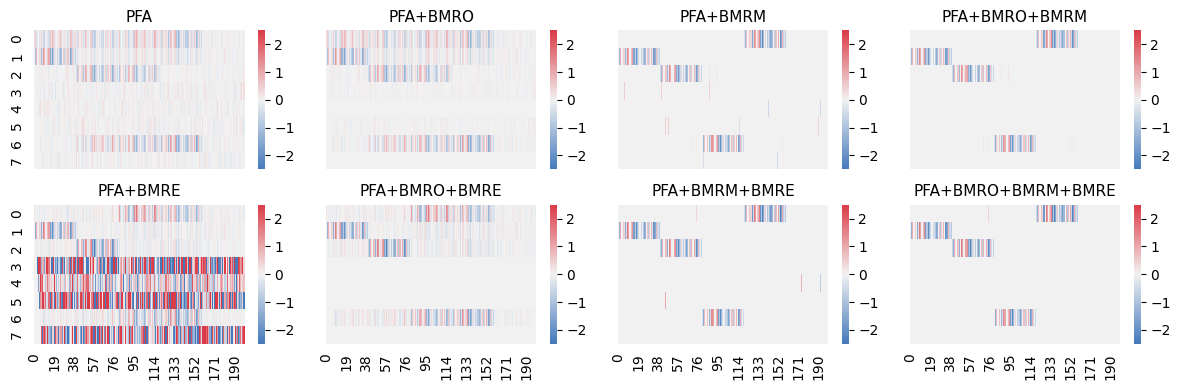

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    W = fit_models[i].q_w_psi.mvn.mean.T
    sns.heatmap(W, cmap = div, fmt = ".2f", center = 0, ax=ax, vmax=2.5, vmin=-2.5)
    ax.tick_params(left=False, bottom=False)
    ax.set_title(labels[i], fontsize=11)

sns.despine(fig, left=True, bottom=True)
fig.tight_layout()

In [ ]:
def generate_data(key, datasize=100, effect_size=1., factor_sparsity=0.5):
    n_fact = 6
    key, _key = jr.split(key)
    z = jr.normal(_key, shape=(datasize, n_fact))
    key, _key = jr.split(key)
    z = z * jr.bernoulli(_key, p=factor_sparsity, shape=(datasize, n_fact))
    W = []
    tmp = jnp.arange(800)
    for i in [0, 400, 500, 600, 680, 740]:
        W.append(1.0 * (tmp >= i))
    W = jnp.stack(W, 0) * jr.normal(_key, shape=(n_fact, 800)) * effect_size
    loc = z @ W

    eps = jr.normal(_key, shape=(datasize, 800))

    return loc + eps, W, z

key = jr.PRNGKey(0)

X, W, Z = generate_data(key, datasize=100, effect_size=1., factor_sparsity=0.5)
print(X.shape, Z.shape, W.shape)

(100, 800) (100, 6) (6, 800)


In [ ]:
results = susp.infer.susie_pca(X, z_dim = 6, l_dim = 400, tau=10, tol=1e-2, max_iter=500)

Iter [1] | ELBO = -78659.560 | E[logl] = -60525.566 | -KL[Z] = -7012.633 | -KL[W] = -10245.172 | -KL[G] = -876.189
Iter [2] | ELBO = -61977.930 | E[logl] = -54556.987 | -KL[Z] = -2775.056 | -KL[W] = -2793.610 | -KL[G] = -1852.277
Iter [3] | ELBO = -59504.671 | E[logl] = -52885.966 | -KL[Z] = -2346.201 | -KL[W] = -2374.971 | -KL[G] = -1897.532
Iter [4] | ELBO = -58272.586 | E[logl] = -52006.463 | -KL[Z] = -2115.660 | -KL[W] = -2181.980 | -KL[G] = -1968.483
Iter [5] | ELBO = -57542.985 | E[logl] = -51407.385 | -KL[Z] = -1971.416 | -KL[W] = -2155.612 | -KL[G] = -2008.573
Iter [6] | ELBO = -57071.539 | E[logl] = -51036.088 | -KL[Z] = -1868.289 | -KL[W] = -2151.217 | -KL[G] = -2015.945
Iter [7] | ELBO = -56738.043 | E[logl] = -50769.373 | -KL[Z] = -1789.834 | -KL[W] = -2154.674 | -KL[G] = -2024.162
Iter [8] | ELBO = -56491.517 | E[logl] = -50578.532 | -KL[Z] = -1729.663 | -KL[W] = -2157.065 | -KL[G] = -2026.257
Iter [9] | ELBO = -56305.724 | E[logl] = -50445.244 | -KL[Z] = -1682.669 | -KL[W

[0.33139754 0.31568341 0.33676447 0.33338769 0.33579896 0.39365901]


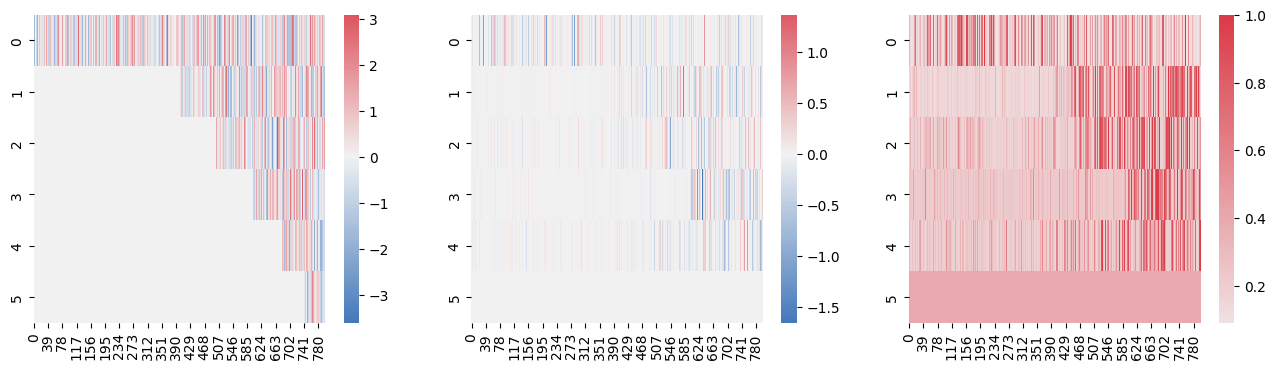

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);
print( pip.sum(-1) / 800 )

Text(0.5, 1.0, 'Sparse PCA')

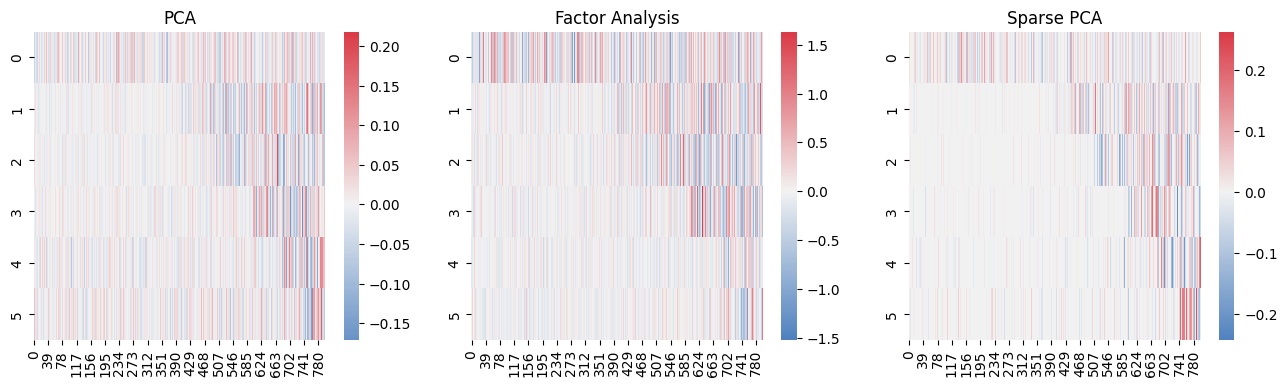

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

z_dim = 6
pca = TruncatedSVD(n_components=z_dim)
res = pca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[0])
axes[0].set_title('PCA')

fa = FactorAnalysis(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[1])
axes[1].set_title('Factor Analysis')

spca = SparsePCA(n_components=z_dim)
res = spca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[2])
axes[2].set_title('Sparse PCA')

In [ ]:
n_components = 6
n_features = 800
key = jr.PRNGKey(5890)
fit_models = []
elbos = []
for bmr_e_step in [False, True]:
    for bmr_m_step in [False, True]:
        for optimize_with_bmr in [False, True]:
            model = PFA(
                n_components=n_components,
                n_features=n_features,
                optimize_with_bmr=optimize_with_bmr,
                bmr_m_step=bmr_m_step,
                bmr_e_step=bmr_e_step,
                bmr_e_step_opts=('max_iter', 4, 'pi', 0.5)
            )
            
            key, _key = jr.split(key)
            fm, elbs = fit(model, X, tol=1e-2, n_iter=256, bmr_frequency=64, key=_key)
            fit_models.append(fm)
            elbos.append(elbs)
            print([bmr_e_step, bmr_m_step, optimize_with_bmr], elbos[-1][-1], len(elbos[-1]))

[False, False, False] -119511.62076229742 256
[False, False, True] -119165.74268299113 256
[False, True, False] -118701.57684394415 120
[False, True, True] -118179.14483679555 71
[True, False, False] -118565.13981693324 256
[True, False, True] -118250.7048997669 256
[True, True, False] -117074.77840937264 256
[True, True, True] -117008.07267925219 256


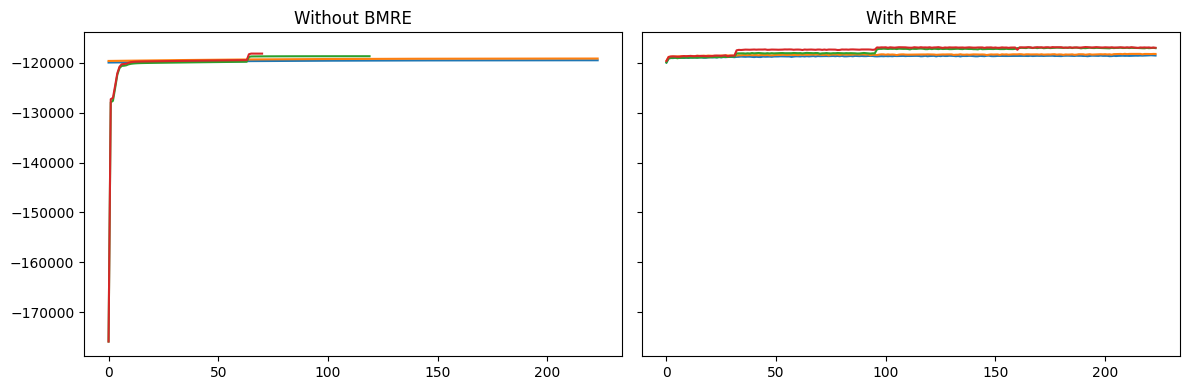

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for elbo in elbos[:4]:
    axes[0].plot(elbo[-256+32:])

axes[0].set_title('Without BMRE')

for elbo in elbos[4:]:
    axes[1].plot(elbo[-256+32:])

axes[1].set_title('With BMRE')

fig.tight_layout()

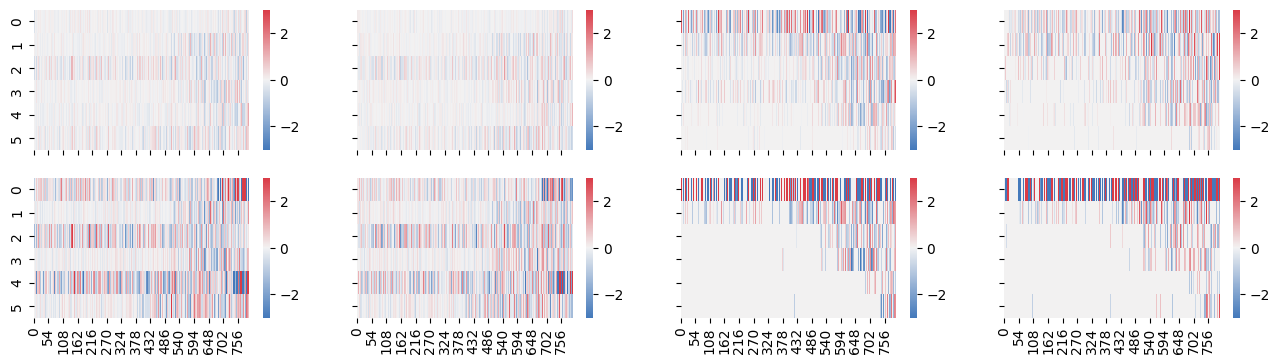

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    W_hat = fit_models[i].q_w_psi.mvn.mean.T
    sorted_idx = jnp.argsort(fit_models[i].q_w_psi.mvn.mask.sum(0))
    sns.heatmap(W_hat[sorted_idx[::-1]], cmap = div, fmt = ".2f", center = 0, ax=ax, vmax=3.0, vmin=-3)


In [49]:
for fm in fit_models[4:]:
    sorted_idx = jnp.argsort(fm.q_w_psi.mvn.mask.sum(0))
    print(fm.q_tau.mean[sorted_idx])
    print(fm.q_w_psi.mvn.mask.sum(0)[sorted_idx])
    print(fm.q_tau.mean[sorted_idx])


[1.41201943 0.16180794 2.72794686 0.95570111 3.16939633 0.46732336]
[795 796 797 798 799 800]
[1.41201943 0.16180794 2.72794686 0.95570111 3.16939633 0.46732336]
[1.54668575 0.30515144 3.39957306 0.98116609 3.9100287  0.98743386]
[795 796 797 798 799 800]
[1.54668575 0.30515144 3.39957306 0.98116609 3.9100287  0.98743386]
[0.25942513 1.11324755 0.45631474 0.92145151 0.48834518 0.00558011]
[ 52  54 149 160 383 511]
[0.25942513 1.11324755 0.45631474 0.92145151 0.48834518 0.00558011]
[4.32795347e-01 1.17321372e+00 6.52960759e-01 6.46098939e-01
 5.04407664e-01 5.32391111e-04]
[ 49  51 130 154 348 550]
[4.32795347e-01 1.17321372e+00 6.52960759e-01 6.46098939e-01
 5.04407664e-01 5.32391111e-04]


<Axes: >

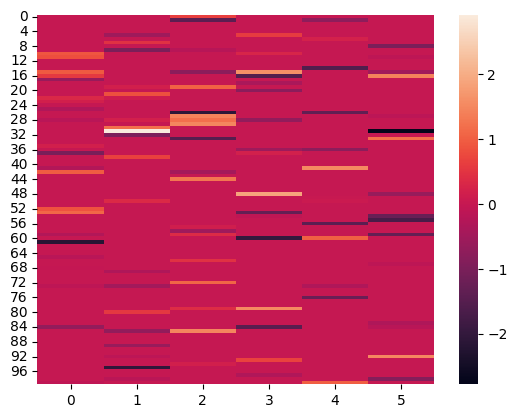

In [ ]:
sns.heatmap(Z)

<Axes: >

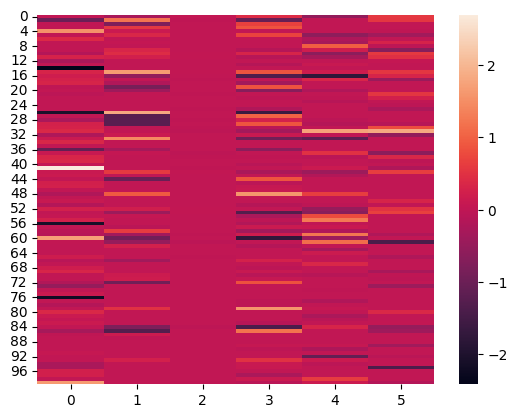

In [55]:
key, _key = jr.split(key)
qz = transform(fm, X, use_bmr=True, key=_key)

sns.heatmap(qz.mean)

<Axes: >

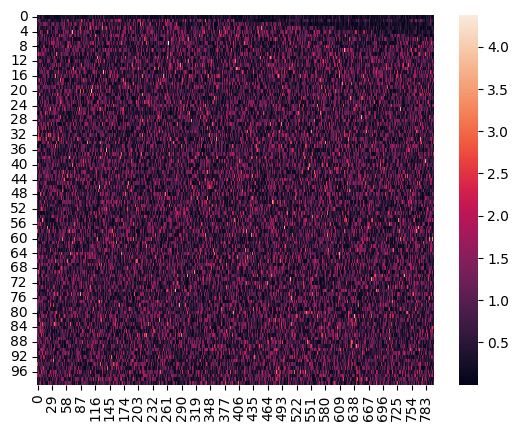

In [59]:
X_reconstructed = inverse_transform(fm, qz)

sns.heatmap(jnp.abs(X - X_reconstructed.mean))